<a href="https://colab.research.google.com/github/antarleen/Torching-Data/blob/main/ANN_for_Regression_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the libraries**

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Feature Engineering the dataset**

In [5]:
df = pd.read_csv('NYCTaxiFares.csv')

In [6]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [7]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

**Creating a Haversine Function to convert GPS into distance**

In [8]:
def haversine_distance(df,lat1,lat2,long1,long2):
  r = 6371
  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])
  lambda1 = np.radians(df[long1])
  lambda2 = np.radians(df[long2])
  delta_phi = phi2 - phi1
  delta_lambda = lambda2 -lambda1
  d = 2 * r * np.arcsin(np.sqrt(np.sin(delta_phi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2))
  return d

In [9]:
df['distance'] = haversine_distance(df,'pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude')

In [10]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


**Fixing the timestamp data to make it more relevant to our application**

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [13]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [14]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [15]:
df['Hour'] = df['EDTdate'].dt.hour

In [16]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22


In [17]:
df['AMorPM'] = np.where(df['Hour']<12,'AM','PM')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM


In [18]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM,Fri


In [19]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

**Dealing with categorical data**

In [20]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'distance'] 
y_col = ['fare_amount']

In [21]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance                         float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [22]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [23]:
hr = df['Hour'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values

In [24]:
cats = np.stack([hr,ampm,wkdy],axis=1)
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [25]:
cats = torch.tensor(cats,dtype=torch.int64)

**Dealing with continuous data**

In [26]:
conts = np.stack([df[col].values for col in cont_cols],1)
conts = torch.tensor(conts,dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [27]:
y = torch.tensor(df[y_col].values,dtype=torch.float)

In [28]:
cats.shape

torch.Size([120000, 3])

In [29]:
conts.shape

torch.Size([120000, 6])

In [30]:
y.shape

torch.Size([120000, 1])

**Setting the embedding sizes in the categories(One Hot Encoding)**

In [31]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [32]:
# Emebedding sizes is the number of unique entries divided by two but we max out at 50
emb_sizes = [(size,min(50,(size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

# **Creating the ANN Model**

Creating the Embedding layer

In [52]:
class TabularModel(nn.Module):
  def __init__(self,emb_sizes,n_cont,out_size,layers,p=0.5):
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_sizes])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont) #Normalizes the continuous data 

    layerlist=[]
    n_embs = sum([nf for ni,nf in emb_sizes])
    n_in = n_embs + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1],out_size))
            
    self.layers = nn.Sequential(*layerlist)
    
  def forward(self,x_cat,x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))
      
    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)
    x = self.layers(x)
    return x
    

# **Training and Testing the Regression Model**

In [53]:
torch.manual_seed(33)
model = TabularModel(emb_sizes,conts.shape[1],1,layers=[200,100],p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [54]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [58]:
batch_size = 120000
test_size = int(batch_size * 0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [59]:
import time
start_time = time.time()
epochs = 300
losses=[]
for i in range(epochs):
  y_pred = model(cat_train,con_train)
  loss = torch.sqrt(criterion(y_pred,y_train))
  losses.append(loss)

  if i%10 == 1:
    print(f'epoch {i} loss is {loss}')
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

duration = time.time() - start_time
print(f'Triaining took {duration/60} minutes')

epoch 1 loss is 3.6791272163391113
epoch 11 loss is 3.6561949253082275
epoch 21 loss is 3.6309714317321777
epoch 31 loss is 3.593764543533325
epoch 41 loss is 3.582611560821533
epoch 51 loss is 3.576390027999878
epoch 61 loss is 3.5731663703918457
epoch 71 loss is 3.522648811340332
epoch 81 loss is 3.5148634910583496
epoch 91 loss is 3.497692108154297
epoch 101 loss is 3.508401870727539
epoch 111 loss is 3.480943441390991
epoch 121 loss is 3.471074342727661
epoch 131 loss is 3.461740732192993
epoch 141 loss is 3.4406917095184326
epoch 151 loss is 3.4205822944641113
epoch 161 loss is 3.4431886672973633
epoch 171 loss is 3.397984504699707
epoch 181 loss is 3.382335662841797
epoch 191 loss is 3.3775641918182373
epoch 201 loss is 3.3915483951568604
epoch 211 loss is 3.3590633869171143
epoch 221 loss is 3.352407932281494
epoch 231 loss is 3.3464839458465576
epoch 241 loss is 3.3470046520233154
epoch 251 loss is 3.325552463531494
epoch 261 loss is 3.3191018104553223
epoch 271 loss is 3.32160

**Plotting out the loss function**

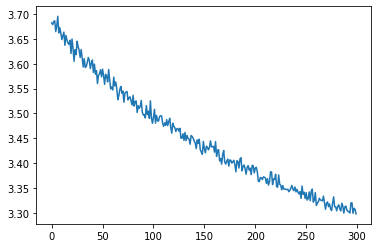

In [60]:
plt.plot(range(epochs),losses)

In [62]:
with torch.no_grad():
  y_val = model(cat_test,con_test)
  loss = torch.sqrt(criterion(y_val,y_test))

In [63]:
loss

tensor(3.3511)

In [66]:
for i in range(10):
  print(f'{i+1} -->  PREDICTED: {y_val[i].item():8.2f} TRUE: {y_test[i].item():8.2f} DIFFERENCE: {np.abs(y_val[i].item()-y_test[i].item()):8.5f}')

1 -->  PREDICTED:     8.93 TRUE:     8.10 DIFFERENCE:  0.83411
2 -->  PREDICTED:    15.43 TRUE:    12.10 DIFFERENCE:  3.33145
3 -->  PREDICTED:     5.61 TRUE:     4.90 DIFFERENCE:  0.71011
4 -->  PREDICTED:    17.35 TRUE:    15.30 DIFFERENCE:  2.05217
5 -->  PREDICTED:     8.99 TRUE:    11.30 DIFFERENCE:  2.31470
6 -->  PREDICTED:    16.70 TRUE:    16.50 DIFFERENCE:  0.19507
7 -->  PREDICTED:     4.23 TRUE:     3.30 DIFFERENCE:  0.92646
8 -->  PREDICTED:     6.58 TRUE:     4.50 DIFFERENCE:  2.08270
9 -->  PREDICTED:     5.38 TRUE:     5.70 DIFFERENCE:  0.31822
10 -->  PREDICTED:    16.91 TRUE:    20.10 DIFFERENCE:  3.19359


**Saving the model**

In [ ]:
torch.save(model.state_dict(),'taxiFareModel.pt')